In [1]:
import sys
sys.path.append('src')
import numpy as np
from tqdm import tqdm
from scipy.special import erf, erfinv
from scipy.sparse import issparse
from matplotlib import colormaps
import matplotlib.pyplot as plt
from models import *
from utils import *
from train_funcs import *
from visualization import *
rng = np.random.default_rng()

## Model Training

In [2]:
NE, NI, N_syl, N_HVC_per_syl = 600, 150, 3, 3
N_HVC = N_syl * N_HVC_per_syl

In [3]:
peak_rate, kernel_width = 150, 20

In [4]:
T_rend = 600 # Each rendition
N_rend = 25 # Number of renditions
T_burn = 500 # Burning
T = T_burn + N_rend * T_rend # Total

In [5]:
# Syllables and time stamps
# syl = rng.normal(1, 3, size=(N_syl, NE))#.clip(min=0)
N_shared_channels = 1
syl_cov = block_sym_mat(NE, K=N_shared_channels, var=9, cov=7.5)
syl = rng.multivariate_normal(np.ones(NE), syl_cov, size=N_syl)
print(syl.shape)
tsyl_start, tsyl_end, burst_ts = generate_syl_time(T, T_burn, T_rend, N_syl, N_HVC)
save_W_ts = np.round(tsyl_end[-1]).astype(int)

(3, 600)


In [6]:
_ = rng.standard_normal((N_HVC, N_rend)) * 0 # Little fluctuation
rH = generate_HVC(T, burst_ts, peak_rate+_, kernel_width+_)

In [7]:
# (T, NE)
aud = generate_discrete_aud(T, NE, tsyl_start, tsyl_end, syl)
# aud[:T_burn] = rng.normal(0, 1, size=(T_burn, NE))

In [8]:
gen = lognormal_gen
# gen = const_gen
c = 0.5
JEE0, JEI0, JIE0, JII0 = np.array([1, 1.7, 1.2, 1.8]) / 4
sEE, sEI, sIE, sII = np.array([JEE0, JEI0, JIE0, JII0]) * 0.1
JEE = generate_matrix(NE, NE, gen, c, rng=rng, mean=JEE0, std=sEE, sparse=c<=0.5) / np.sqrt(NE)
JEI = generate_matrix(NE, NI, gen, c, rng=rng, mean=JEI0, std=sEI, sparse=c<=0.5) / np.sqrt(NI)
JIE = generate_matrix(NI, NE, gen, c, rng=rng, mean=JIE0, std=sIE, sparse=c<=0.5) / np.sqrt(NE)
JII = generate_matrix(NI, NI, gen, c, rng=rng, mean=JII0, std=sII, sparse=c<=0.5) / np.sqrt(NI)
J0_mean = JEE0 / np.sqrt(NE) * c

In [9]:
rEmax, rImax, thE, thI, sE, sI = 50, 100, -4, 0, 2, 2
phiE = lambda x: rEmax/2 * (1 + erf((x - thE) / (np.sqrt(2) * sE)))
phiI = lambda x: rImax/2 * (1 + erf((x - thI) / (np.sqrt(2) * sI)))

In [10]:
r_rest = 2 # target rate when phi(0)
rmax, s = 50, 2
th = -erfinv(r_rest * 2 / rmax - 1) * (np.sqrt(2) * s)
phi = lambda x: rmax/2 * (1 + erf((x - th) / (np.sqrt(2) * s)))

In [11]:
w0_mean_HVC2E, w0_std_HVC2E = 1/N_HVC, 0
w0_mean_E2E, w0_std_E2E, cW_E2E = 1/N_HVC, 0, 0.05
w_inh_HVC2E = w0_mean_HVC2E
w_inh_E2E = w0_mean_E2E*cW_E2E
tauE, tauI, dt = 30, 10, 1

In [12]:
netFF = WCNet(NE, N_HVC, w0_mean_HVC2E, phi, tauE, 
              w_inh=w_inh_HVC2E, w0_std=w0_std_HVC2E)
netEI = EINet(NE, NI, N_HVC, w0_mean_HVC2E, phiE, phiI, tauE, tauI, 
              JEE=JEE.copy(), JEI=JEI.copy(), JIE=JIE.copy(), JII=JII.copy(), 
              w_inh=w_inh_HVC2E, w0_std=w0_std_HVC2E)
netEIrec = EINet(NE, NI, N_HVC, w0_mean_E2E, phiE, phiI, tauE, tauI, 
                 JEE=JEE.copy(), JEI=JEI.copy(), JIE=JIE.copy(), JII=JII.copy(), 
                 w_inh=w_inh_E2E, w0_std=w0_std_E2E, cW=cW_E2E)

Not a recurrent model and rI will not be calculated.


In [13]:
hE0 = rng.normal(loc=-10, scale=0.5, size=NE)
hI0 = rng.normal(loc=-1, scale=0.5, size=NI)
plasticity_kwargs = dict(plasticity=bilin_hebb_E_HVC, lr=-5e-2, 
                         tauW=1e5, asyn_H=0, rE_th=1)
_ = netFF.sim(hE0, rH, aud, save_W_ts, T, dt, 0, **plasticity_kwargs)
WsFF = _[2]
plasticity_kwargs = dict(plasticity=dict(HVC=bilin_hebb_E_HVC), lr=dict(HVC=-8e-2), 
                         tauW=1e5, asyn_H=0, rE_th=1)
_ = netEI.sim(hE0, hI0, rH, aud, save_W_ts, T, dt, 0, **plasticity_kwargs)
WsEI = _[2]
plasticity_kwargs = dict(plasticity=dict(JEE=bilin_hebb_EE), lr=dict(JEE=-2e-1), 
                         tauW=1e5, J0_mean=J0_mean, asyn_E=10, rE_th=1)
_ = netEIrec.sim(hE0, hI0, rH, aud, save_W_ts, T, dt, 0, **plasticity_kwargs)
WsEIrec = _[2]

100%|███████████████████████████████████| 15499/15499 [00:14<00:00, 1090.90it/s]


Text(0, 0.5, 'Exc. index')

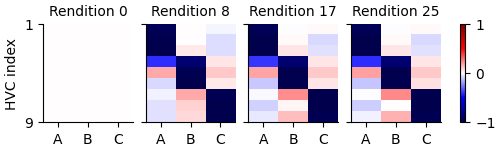

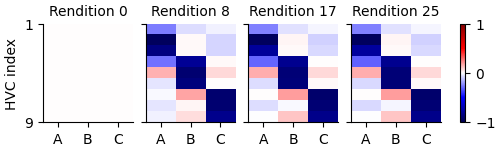

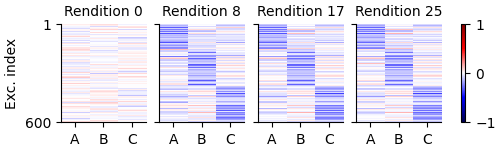

In [14]:
fig, ax = plot_wcol_corr(WsFF, syl, (1, 4), (5, 1.5), sort=True)
ax[0].set_ylabel('HVC index')
fig, ax = plot_wcol_corr(WsEI['HVC'], syl, (1, 4), (5, 1.5), sort=True)
ax[0].set_ylabel('HVC index')
fig, ax = plot_wcol_corr(WsEIrec['JEE'], syl, (1, 4), (5, 1.5), sort=True)
ax[0].set_ylabel('Exc. index')

## Test Model with Different Scenarios

In [15]:
from scipy.linalg import svd
J = np.block([[netEI.JEE.toarray(), -netEI.JEI.toarray()*2], 
              [netEI.JIE.toarray(), -netEI.JII.toarray()*2]])
svd_EI = svd(J)

J = np.block([[netEIrec.JEE.toarray(), -netEIrec.JEI.toarray()*2], 
              [netEIrec.JIE.toarray(), -netEIrec.JII.toarray()*2]])
svd_EIrec = svd(J)

[Text(0.5, 0, 'Index'), Text(0, 0.5, 'Correlation with TS patterns')]

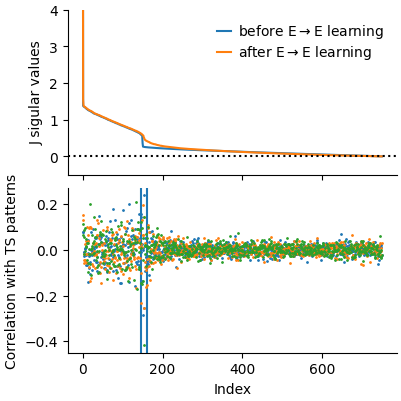

In [70]:
fig, ax = plt.subplots(2, figsize=(4,4), sharex='all')
ax[0].plot(svd_EI[1], label='before E$\\to$E learning')
ax[0].plot(svd_EIrec[1], label='after E$\\to$E learning')
ax[0].axhline(0, ls=':', c='k')
ax[1].axvline(145)
ax[1].axvline(160)
ax[0].set(ylabel='J sigular values', ylim=[-0.5, 4])
ax[0].legend()
c = correlation(svd_EIrec[0][:NE,:].T, syl, dim=2)
ax[1].plot(c, '.', ms=2)
ax[1].set(xlabel='Index', ylabel='Correlation with TS patterns')
# fig.savefig('svg/supplementary/svd_J.svg')

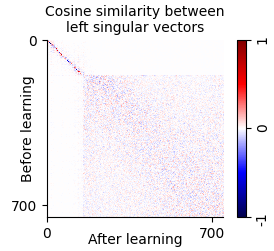

In [17]:
fig, ax = plt.subplots(1, figsize=(3, 2.5))
im = ax.imshow(svd_EI[0].T @ svd_EIrec[0], vmin=-1, vmax=1, 
               interpolation='none', cmap='seismic', aspect=1)
ax.set(xticks=[0,700], yticks=[0,700],
       title='Cosine similarity between\nleft singular vectors')
ax.set_xlabel('\nAfter learning', va='bottom')
ax.set_ylabel('\nBefore learning', va='top')
cax = fig.colorbar(im, ax=ax, fraction=0.04)
cax.set_ticks([-1,0,1], labels=[-1,0,1], rotation=90)
fig.savefig('svg/left_sv_similarity.svg')

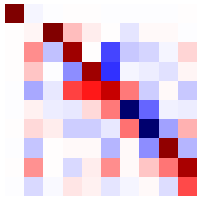

In [18]:
fig, ax = plt.subplots(1, figsize=(2,2))
i = 10
ax.imshow(svd_EI[0][:,:i].T @ svd_EIrec[0][:,:i], vmin=-1, vmax=1, 
          interpolation='none', cmap='seismic', aspect=1)
ax.set_axis_off()
fig.savefig('svg/left_sv_similarity_zoomin.png')

In [43]:
def disrupt_conn(svd, idx_disrupt, shuff_I=False):
    ''' Shuffle selected left singular vectors (modes) and generate the disrupted network
    svd: Output of scipy.linalg.svd
    idx_disrupt: list of mode indices
    shuff_I: if True, the entries corresponding to the inh. neurons will be shuffled;
             otherwise, only those corresponding to the exc. neurons will be shuffled.
    '''
    idx = [i for i in range(NE+NI) if i not in idx_disrupt]
    J_trunc = svd[0][:,idx] @ np.diag(svd[1][idx]) @ svd[2][idx,:]

    # shuffle U and V, one mode at a time
    U, V = np.zeros((NE+NI,len(idx_disrupt))), np.zeros((len(idx_disrupt),NE+NI))
    for i, j in enumerate(idx_disrupt):
        idxE, idxI = np.arange(NE), np.arange(NI)
        rng.shuffle(idxE)
        if shuff_I:
            rng.shuffle(idxI)
        idx = np.concat([idxE, idxI+NE])
        U[:,i], V[i,:] = svd[0][idx,j], svd[2][j,idx]
        
    aux = U @ np.diag(svd[1][idx_disrupt]) @ V
    J_disrupt = J_trunc + aux
    
    netEIrec_disrupt = EINet(NE, NI, N_HVC, w0_mean_E2E, phiE, phiI, tauE, tauI, 
                             JEE=J_disrupt[:NE,:NE], JEI=-J_disrupt[:NE,NE:]/2, 
                             JIE=J_disrupt[NE:,:NE], JII=-J_disrupt[NE:,NE:]/2, 
                             w_inh=w_inh_E2E, w0_std=w0_std_E2E, cW=cW_E2E)
    netEIrec_disrupt.W = netEIrec.W.copy()

    return netEIrec_disrupt, J_disrupt, J_trunc

In [71]:
T_test = T_burn + T_rend
i_pert = 1
pert_cov = block_sym_mat(NE, K=N_shared_channels, var=9, cov=7.5)
N_shuffles = 20
res = dict(EIrecJshuff=[], EIrec=[], Js=[], pert=[])
for i in tqdm(range(N_shuffles)):
    netEIrecJshuff, J_disrupt, J_trunc = disrupt_conn(svd_EIrec, list(range(1,16)))
    res['Js'].append(J_disrupt)
    
    hE0 = rng.normal(loc=-10, scale=0.5, size=NE)
    hI0 = rng.normal(loc=-1, scale=0.5, size=NI)
    pert = rng.multivariate_normal(np.zeros(NE), pert_cov)
    res['pert'].append(pert)

    liJshuff, li = [], []
    for j, (p, q) in enumerate(((1,0),(0,1))):
        bos = syl.copy()
        bos[i_pert] = syl[i_pert] * p + pert * q
        aud_test = generate_discrete_aud(T_test, NE, tsyl_start[:,:1], tsyl_end[:,:1], bos)
        args = (hE0, hI0, rH[:T_test], aud_test, [], T_test, dt, 0)
        liJshuff.append(np.hstack(netEIrecJshuff.sim(*args, no_progress_bar=True)[:2]))
        li.append(np.hstack(netEIrec.sim(*args, no_progress_bar=True)[:2]))
    res['EIrecJshuff'].append(np.stack(liJshuff,0))
    res['EIrec'].append(np.stack(li,0))

100%|███████████████████████████████████████████| 20/20 [00:21<00:00,  1.08s/it]


TtestResult(statistic=np.float64(4.336810768333094), pvalue=np.float64(0.00017765262675570757), df=np.int64(19))

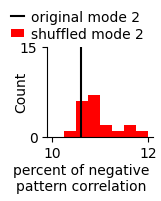

In [72]:
p_neg_corrs = np.zeros(N_shuffles+1)
p_neg_corrs[0] = (correlation(netEIrec.JEE.toarray(), syl, dim=2) < -0.1).mean()*100
for i, j in enumerate(res['Js'], 1):
    p_neg_corrs[i] = (correlation(j[:NE,:NE], syl, dim=2) < -0.1).mean()*100
fig, ax = plt.subplots(1, figsize=(1.6,2))
ax.axvline(p_neg_corrs[0], c='k', label='original mode 2')
ax.hist(p_neg_corrs[1:], bins=8, color='r', label='shuffled mode 2',
        range=(np.floor(p_neg_corrs.min()), np.ceil(p_neg_corrs.max())))
fig.text(0.5, 0.05, 'percent of negative\npattern correlation', ha='center')
ax.set(xlabel='$\ $\n', yticks=[0, 15])
ax.set_ylabel('Count', va='top')
ax.legend(loc=(-0.4, 1))
# fig.savefig('svg/percent_J_corr_less_-0.1.svg')
from scipy.stats import ttest_1samp
ttest_1samp(p_neg_corrs[1:], p_neg_corrs[0], alternative='greater')

[Text(0.5, 1.0, 'shuffled\nmode 2')]

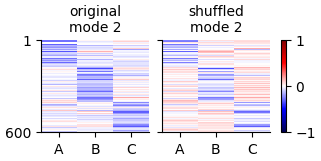

In [73]:
fig, ax = plot_wcol_corr([netEIrec.JEE.toarray(), res['Js'][0][:NE,:NE]], syl, 
                         (1, 2), (3.2, 1.6), sort=True)
ax[0].set(title='original\nmode 2')
ax[1].set(title='shuffled\nmode 2')
# fig.savefig('svg/supplementary/J_corr_patterns.svg')

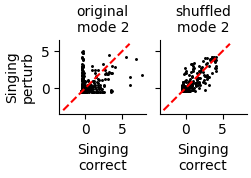

In [74]:
ti, tj = int(tsyl_start[i_pert,0]), int(tsyl_end[i_pert,0])+100
fig, ax = plt.subplots(1, 2, sharex='all', sharey='all', figsize=(2.5, 2))
l = 0
err = res['pert'][l] - syl[i_pert]
for i, k in enumerate(('EIrec', 'EIrecJshuff')):
    z_ctrl = normalize(res[k][l][0,ti:tj,:NE].mean(axis=0), axis=0)
    z_pert = normalize(res[k][l][1,ti:tj,:NE].mean(axis=0), axis=0)
    # z_ctrl = res[k][l][0,ti:tj,:NE].mean(axis=0)
    # z_pert = res[k][l][1,ti:tj,:NE].mean(axis=0)
    # ax[i].scatter(z_ctrl, z_pert, c=err, s=5, cmap='plasma')
    ax[i].scatter(z_ctrl, z_pert, c='k', s=5)
    ax[i].plot([-3,6], [-3,6], c='r', ls='--')
    # ax[i].set(aspect=1, xlim=[-3,6], ylim=[-3,6])
    ax[i].set(aspect=1)
ax[0].set(title='original\nmode 2', xlabel='Singing\ncorrect', ylabel='Singing\nperturb')
ax[1].set(title='shuffled\nmode 2', xlabel='Singing\ncorrect')
fig.savefig('svg/joint_dist_J_J_shuff.svg')

In [23]:
spon_rates = np.zeros((2,N_shuffles))
ctrl_rates = np.zeros((2,N_shuffles))
pert_rates = np.zeros((2,N_shuffles))
dims = np.zeros((2,N_shuffles))

ti, tj = int(tsyl_start[i_pert,0]), int(tsyl_end[i_pert,0])
t_pca_start, t_pca_end = T_burn+50, int(tsyl_end[-1,0])
for i, k in enumerate(('EIrec', 'EIrecJshuff')):
    for j in tqdm(range(N_shuffles)):
        spon_rates[i,j] = res[k][j][0,100:T_burn,:NE].mean()
        ctrl_rates[i,j] = res[k][j][0,ti:tj,:NE].mean()
        pert_rates[i,j] = res[k][j][1,ti:tj,:NE].mean()
        pca = PCA_proj(res[k][j][1,t_pca_start:t_pca_end,:NE], None, normalize_data=True)
        dims[i,j] = pca[1].sum()**2/(pca[1]**2).sum()

100%|███████████████████████████████████████████| 30/30 [00:05<00:00,  5.79it/s]


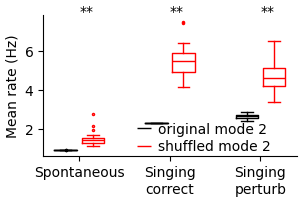

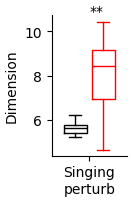

In [24]:
fig1, ax1 = plt.subplots(1, figsize=(3,2), sharey='all')
fig2, ax2 = plt.subplots(1, figsize=(1.3,2), sharey='all')
pos = np.array([0, 2, 4])
for i, k in enumerate(('EIrec', 'EIrecJshuff')):
    l = 'original mode 2' if i == 0 else 'shuffled mode 2'
    c = 'k' if i==0 else 'r'
    bp1 = ax1.boxplot([spon_rates[i], ctrl_rates[i], pert_rates[i]], 
                      positions=pos if i==0 else pos+0.6, label=l, widths=[0.5]*3)
    bp2 = ax2.boxplot(dims[i], positions=[i*0.6], widths=[0.5])
    for element in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
        plt.setp(bp1[element], color=c)
        plt.setp(bp2[element], color=c)
    plt.setp(bp1['fliers'], mec=c)
    plt.setp(bp2['fliers'], mec=c)

from scipy.stats import permutation_test
stats = lambda x, y: np.mean(x) - np.mean(y)
p_spon = permutation_test(spon_rates, stats, n_resamples=3999)
p_ctrl = permutation_test(ctrl_rates, stats, n_resamples=3999)
p_pert = permutation_test(pert_rates, stats, n_resamples=3999)
p_dim = permutation_test(dims, stats, n_resamples=3999)

for i, p in enumerate((p_spon, p_ctrl, p_pert)):
    if p.pvalue < 0.001:
        ax1.text(i*2+0.3, ax1.get_ylim()[1], '**')
if p_dim.pvalue < 0.001:
    ax2.text(0.3, ax2.get_ylim()[1], '**')

ax1.set(xticks=pos+0.3, ylabel='Mean rate (Hz)', 
        xticklabels=['Spontaneous', 'Singing\ncorrect', 'Singing\nperturb'])
ax1.legend(loc=(0.35, -0.02))
ax2.set(xticks=[0.3], xticklabels=['Singing\nperturb'], xlim=[-0.5, 1.1],
        ylabel='Dimension')
fig1.savefig('svg/rates_J_J_shuff.svg')
fig2.savefig('svg/dim_J_J_shuff.svg')

In [25]:
# t_pca_start, t_pca_end = T_burn, int(tsyl_end[-1,0])+50
# pcaFF = PCA_proj(res['FF'][:,t_pca_start:t_pca_end,:NE])
# pcaEI = PCA_proj(res['EI'][:,t_pca_start:t_pca_end,:NE])
# pcaEIrec = PCA_proj(res['EIrec'][:,t_pca_start:t_pca_end,:NE])

# fig, ax = plt.subplots(1, 4, figsize=(7, 2), sharey='col')
# ax[0].set(ylabel='PC2')
# arrow_origin = ((0, 20), (0, 10), (0, 0))
# titles = ('Feedforward', 'EI network (HVC$\\to$E)', 'EI network (E$\\to$E)')
# for k, (pca, title) in enumerate(zip((pcaFF, pcaEI, pcaEIrec), titles)):
#     draw_traj(ax[k], pca[2][:,:,[0,1]], ('Greys', 'Blues', 'Oranges'), (2, 1, 0))

#     # draw error direction
#     draw_vec(ax[k], arrow_origin[k], pca[0][[0,1]]@(pert-syl[i_pert]), 0.2, 'r')
#     # draw_vec(ax[k], arrow_origin[k], pca[0][[0,1]]@syl[i_pert], 0.2, 'g')
#     # draw_vec(ax[k], arrow_origin[k], pca[0][[0,1]]@pert, 0.2, 'b')
    
#     ax[k].set(title=title)
#     ax[k].set(xlabel='PC1')
    
# # dummy
# ax[-1].set_axis_off()
# ax[-1].set(xlim=[-1,1], ylim=[-1,1])
# draw_vec(ax[-1], (-0.9,-0.8), np.array((-1,0)), 0.2, 'r')
# ax[-1].text(-0.8, -0.8, 'Error direction', ha='left', va='center')
# l1, = ax[-1].plot(0, 0, c='k', label='Singing correct')
# l2, = ax[-1].plot(0, 0, c='b', label='\nSinging\nweak perturb.')
# l3, = ax[-1].plot(0, 0, c='chocolate', label='\nSinging\nstrong perturb.')
# fig.legend(handles=[l1], loc=(0.78, 0.8))
# fig.legend(handles=[l2], loc=(0.78, 0.6))
# fig.legend(handles=[l3], loc=(0.78, 0.4))
# fig.savefig('svg/PCA_traj_weak_strong_pert.svg')